**Классификация отзывов к фильмам по рейтингу и позитивности**

In [1]:
!pip install nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import shutil
import string
import pickle
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from wordcloud import WordCloud
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses



In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
STOP_WORDS = set(stopwords.words('english'))

RANDOM_STATE = 42

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=b942b5deedf9bb29e49a94cb043318583851e17a3ea2c894ddc3e191f6e2ca6c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
import wget

In [5]:
wget.download("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")

'aclImdb_v1.tar.gz'

In [6]:
train_data=[]

In [7]:
test_data=[]

In [8]:
import tarfile

# open file
file = tarfile.open('aclImdb_v1.tar.gz')

# print file names
print(file.getnames())

# extract files
file.extractall('./Destination_FolderName')

# close file
file.close()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
for filename in os.listdir('./Destination_FolderName/aclImdb/train/neg'):
    id=filename.split('.')[0].split('_')[0]
    rat=filename.split('.')[0].split('_')[1]
    #str=
    with open("./Destination_FolderName/aclImdb/train/neg/"+filename) as file_in:
        lines = []
        for line in file_in:
            lines.append(line)
            lines=''.join(lines)
    train_data.append([id,lines,rat,'neg'])

In [10]:
for filename in os.listdir('./Destination_FolderName/aclImdb/train/pos'):
    id=filename.split('.')[0].split('_')[0]
    rat=filename.split('.')[0].split('_')[1]
    #str=
    with open("./Destination_FolderName/aclImdb/train/pos/"+filename) as file_in:
        lines = []
        for line in file_in:
            lines.append(line)
            lines=''.join(lines)
    train_data.append([id,lines,rat,'pos'])

In [11]:
train_data = pd.DataFrame(train_data)
train_data

,0,1,2,3
0,9484,If I have to give this movie a score on a line...,3,neg
1,9815,This movie starts presenting a somehow origina...,2,neg
2,12062,When great director/actor combinations are tal...,4,neg
3,9236,I'm among millions who consider themselves Car...,1,neg
4,3778,Decent animation and some workable character d...,3,neg
...,...,...,...,...
24995,5240,Some of the acting was a bit suspect. I rememb...,7,pos
24996,11311,fascinating look at fascist italy and the peop...,10,pos
24997,1222,I spied this short on a DVD of best new Zealan...,10,pos
24998,9574,This has to be one of the best movies to come ...,9,pos


In [12]:
train_data = train_data.rename(columns={0: 'id', 1: 'review',2: 'rating',3: 'positive',})
train_data

,id,review,rating,positive
0,9484,If I have to give this movie a score on a line...,3,neg
1,9815,This movie starts presenting a somehow origina...,2,neg
2,12062,When great director/actor combinations are tal...,4,neg
3,9236,I'm among millions who consider themselves Car...,1,neg
4,3778,Decent animation and some workable character d...,3,neg
...,...,...,...,...
24995,5240,Some of the acting was a bit suspect. I rememb...,7,pos
24996,11311,fascinating look at fascist italy and the peop...,10,pos
24997,1222,I spied this short on a DVD of best new Zealan...,10,pos
24998,9574,This has to be one of the best movies to come ...,9,pos


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        25000 non-null  object
 1   review    25000 non-null  object
 2   rating    25000 non-null  object
 3   positive  25000 non-null  object
dtypes: object(4)
memory usage: 781.4+ KB


In [14]:
train_data['positive']=train_data['positive'].map({
                               'neg':0,
                               'pos':1,
                                })

In [15]:
train_data

,id,review,rating,positive
0,9484,If I have to give this movie a score on a line...,3,0
1,9815,This movie starts presenting a somehow origina...,2,0
2,12062,When great director/actor combinations are tal...,4,0
3,9236,I'm among millions who consider themselves Car...,1,0
4,3778,Decent animation and some workable character d...,3,0
...,...,...,...,...
24995,5240,Some of the acting was a bit suspect. I rememb...,7,1
24996,11311,fascinating look at fascist italy and the peop...,10,1
24997,1222,I spied this short on a DVD of best new Zealan...,10,1
24998,9574,This has to be one of the best movies to come ...,9,1


In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        25000 non-null  object
 1   review    25000 non-null  object
 2   rating    25000 non-null  object
 3   positive  25000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 781.4+ KB


In [17]:
train_data['rating'] = train_data['rating'].astype (int)
train_data['id'] = train_data['id'].astype (int)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        25000 non-null  int64 
 1   review    25000 non-null  object
 2   rating    25000 non-null  int64 
 3   positive  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB


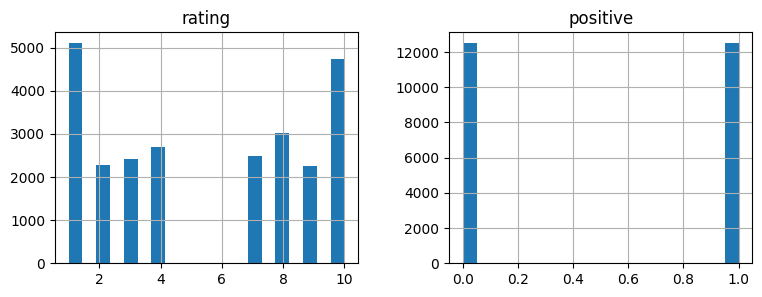

In [18]:
train_data[['rating', 'positive']].hist(bins=20, figsize=(9,3))
plt.show()

In [19]:
train_data['rating'].value_counts()

1     5100
10    4732
8     3009
4     2696
7     2496
3     2420
2     2284
9     2263
Name: rating, dtype: int64

In [20]:
train_data['positive'].value_counts()

0    12500
1    12500
Name: positive, dtype: int64

In [21]:
train_data.to_csv('imdb_train.csv', index=False)

In [24]:
for filename in os.listdir('./Destination_FolderName/aclImdb/test/neg'):
    id=filename.split('.')[0].split('_')[0]
    rat=filename.split('.')[0].split('_')[1]
    #str=
    with open("./Destination_FolderName/aclImdb/test/neg/"+filename) as file_in:
        lines = []
        for line in file_in:
            lines.append(line)
            lines=''.join(lines)
    test_data.append([id,lines,rat,'neg'])

In [25]:
for filename in os.listdir('./Destination_FolderName/aclImdb/test/pos'):
    id=filename.split('.')[0].split('_')[0]
    rat=filename.split('.')[0].split('_')[1]
    #str=
    with open("./Destination_FolderName/aclImdb/test/pos/"+filename) as file_in:
        lines = []
        for line in file_in:
            lines.append(line)
            lines=''.join(lines)
    test_data.append([id,lines,rat,'pos'])

In [26]:
test_data = pd.DataFrame(test_data)
test_data

,0,1,2,3
0,2716,"Tacky, but mildly entertaining early 90's soft...",3,neg
1,7530,"I don't mean to sound pretentious here, but to...",1,neg
2,9532,This is one of those road movies that would li...,1,neg
3,1858,"Jerry Angell, owner of zombie-horror's finest ...",1,neg
4,9236,Altioklar's populist approach manifests itself...,1,neg
...,...,...,...,...
24995,6550,Uzumaki succeeds as at plunging you into a biz...,7,pos
24996,11311,Julie Brown hilariously demolishes Madonna's a...,10,pos
24997,8987,This movie starts off as a college T'n'A flick...,7,pos
24998,520,Linda Blair has been acting for forty years no...,10,pos


In [27]:
test_data = test_data.rename(columns={0: 'id', 1: 'review',2: 'rating',3: 'positive',})
test_data

,id,review,rating,positive
0,2716,"Tacky, but mildly entertaining early 90's soft...",3,neg
1,7530,"I don't mean to sound pretentious here, but to...",1,neg
2,9532,This is one of those road movies that would li...,1,neg
3,1858,"Jerry Angell, owner of zombie-horror's finest ...",1,neg
4,9236,Altioklar's populist approach manifests itself...,1,neg
...,...,...,...,...
24995,6550,Uzumaki succeeds as at plunging you into a biz...,7,pos
24996,11311,Julie Brown hilariously demolishes Madonna's a...,10,pos
24997,8987,This movie starts off as a college T'n'A flick...,7,pos
24998,520,Linda Blair has been acting for forty years no...,10,pos


In [28]:
test_data['positive']=test_data['positive'].map({
                               'neg':0,
                               'pos':1,
                                })

In [29]:
test_data['rating'] = test_data['rating'].astype (int)
test_data['id'] = test_data['id'].astype (int)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        25000 non-null  int64 
 1   review    25000 non-null  object
 2   rating    25000 non-null  int64 
 3   positive  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB


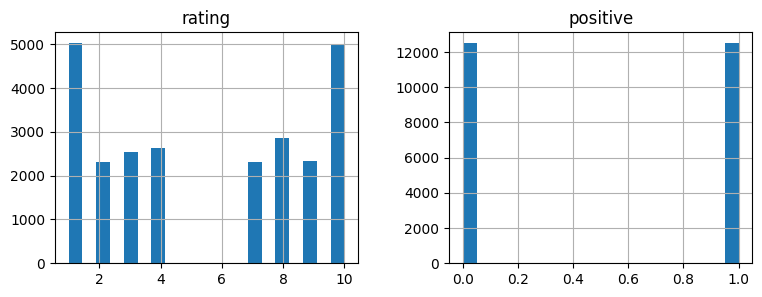

In [30]:
test_data[['rating', 'positive']].hist(bins=20, figsize=(9,3))
plt.show()

In [31]:
test_data['rating'].value_counts()

1     5022
10    4999
8     2850
4     2635
3     2541
9     2344
7     2307
2     2302
Name: rating, dtype: int64

In [32]:
test_data['positive'].value_counts()

0    12500
1    12500
Name: positive, dtype: int64

In [33]:
test_data.to_csv('imdb_test.csv', index=False)

**Таким образом:**

Обучающая и тестовая выборки содержат по 25 тыс. записей с отзывами о фильмах, оценками (1-4 и 7-10) и статусами (1 - позитивный, 0 - негативный).

Пропусков в данных не обнаружено.

Классы статуса сбалансированы 1:1 в обеих выборках (по 12,5 тыс.).

Классы оценок в обучающей и тестовой выборках имеют похожее распределение:

самые популярные оценки - 1 и 10 (по ~5 тыс.);

остальные оценки встречаются реже, но распределены по классам достаточно равномерно (от ~2 до 3 тыс.).

## **Обработка текста**

Очистим текст от лишних символов и стоп-слов, а также проведем лемматизацию с помощью WordNetLemmatizer:

In [34]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text


def strip_all_entities(text):
    text = text.replace('<br />', ' ').replace('\r', '').replace('\n', ' ').lower() #remove <br />, \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = [word for word in text.split() if word not in STOP_WORDS]
    text = ' '.join(text)
    return text


def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
   # return ' '.join([lm.lemmatize(words) for words in tokenized])
    return ' '.join([lm.lemmatize(words, get_wordnet_pos(words)) for words in tokenized])


def deep_clean(text):
    text = decontract(text)
    text = strip_all_entities(text)
    text = remove_mult_spaces(text)
    text = lemmatize(text)
    return text

In [35]:
%%time

train_data['text_clean'] = train_data['review'].apply(deep_clean)

CPU times: user 7min 57s, sys: 24.7 s, total: 8min 21s
Wall time: 8min 27s


In [36]:
train_data.head()

,id,review,rating,positive,text_clean
0,9484,If I have to give this movie a score on a line...,3,0,give movie score linear scale give low score 3...
1,9815,This movie starts presenting a somehow origina...,2,0,movie start present somehow original idea beco...
2,12062,When great director/actor combinations are tal...,4,0,great director actor combination talk team j l...
3,9236,I'm among millions who consider themselves Car...,1,0,among million consider cary grant fan think si...
4,3778,Decent animation and some workable character d...,3,0,decent animation workable character developmen...


In [37]:
%%time

test_data['text_clean'] = test_data['review'].apply(deep_clean)

CPU times: user 7min 39s, sys: 23.9 s, total: 8min 3s
Wall time: 8min 7s


In [38]:
test_data.head()

,id,review,rating,positive,text_clean
0,2716,"Tacky, but mildly entertaining early 90's soft...",3,0,tacky mildly entertain early 90 soft core come...
1,7530,"I don't mean to sound pretentious here, but to...",1,0,mean sound pretentious call next cult classic ...
2,9532,This is one of those road movies that would li...,1,0,one road movie would like tell lotta thing wom...
3,1858,"Jerry Angell, owner of zombie-horror's finest ...",1,0,jerry angell owner zombie horror fine mullet r...
4,9236,Altioklar's populist approach manifests itself...,1,0,altioklar populist approach manifest title bad...


In [39]:
# проверка на дубликаты
train_data['text_clean'].duplicated().sum()

100

In [40]:
# вывод дубликатов
train_data[train_data['text_clean'].duplicated(keep=False)].sort_values(by='text_clean').head(10)

,id,review,rating,positive,text_clean
8442,5582,The 1960's were a time of change and awakening...,3,0,1960 time change awaken people social upheaval...
4278,2715,The 1960's were a time of change and awakening...,3,0,1960 time change awaken people social upheaval...
8175,7871,"In 1993, ""the visitors"" was an enormous hit in...",2,0,1993 visitor enormous hit france sequence inev...
4595,4985,"In 1993, ""the visitors"" was an enormous hit in...",2,0,1993 visitor enormous hit france sequence inev...
3791,5581,The 60s (1999) D: Mark Piznarski. Josh Hamilto...,4,0,60 1999 mark piznarski josh hamilton julia sti...
4441,2714,The 60s (1999) D: Mark Piznarski. Josh Hamilto...,4,0,60 1999 mark piznarski josh hamilton julia sti...
240,5579,"The '60s is an occasionally entertaining film,...",2,0,60 occasionally entertain film entertainment l...
4487,2712,"The '60s is an occasionally entertaining film,...",2,0,60 occasionally entertain film entertainment l...
2573,7345,"I absolutely hate this programme, what kind of...",1,0,absolutely hate programme kind people sit watc...
5315,12318,"I absolutely hate this programme, what kind of...",1,0,absolutely hate programme kind people sit watc...


Построим облака слов для негативных и позитивных отзывов:

In [41]:
def word_cloud(text, title):
    pos_words = " ".join(text)
    pos_wordcloud =  WordCloud(width=800, height=500, collocations=False, stopwords=STOP_WORDS).generate(pos_words)

    plt.figure(figsize=(8, 8), facecolor = None)
    plt.imshow(pos_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title('Most frequently used words in {} reviews'.format(title), fontsize=14)
    plt.show()

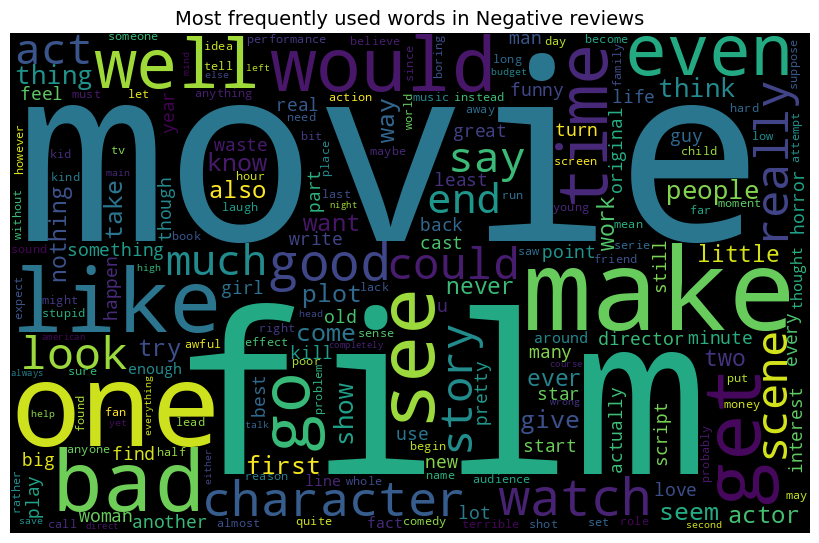

In [42]:
word_cloud(train_data.query('positive==0')['text_clean'], 'Negative')

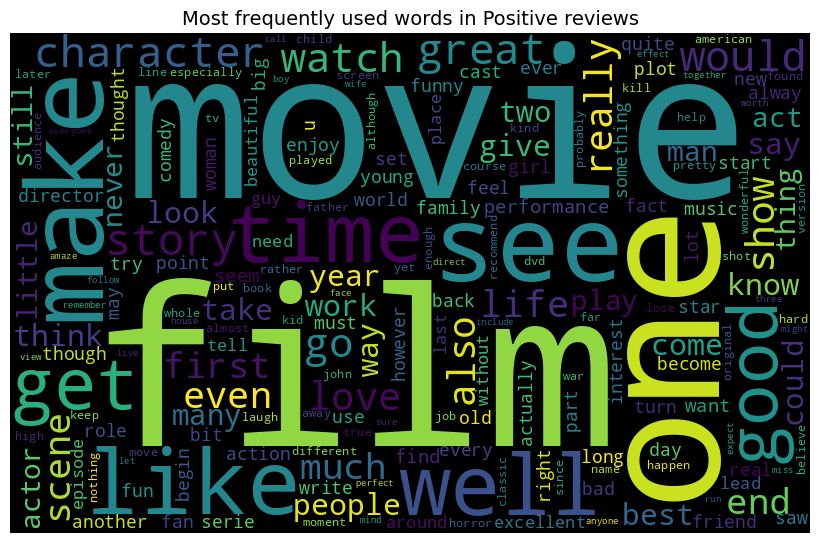

In [43]:
word_cloud(train_data.query('positive==1')['text_clean'], 'Positive')

Наиболее популярные слова во многом совпадают (film, movie, one, see, make, like и др.), но при этом есть и заметные отличия: например, в негативных отзывах намного чаще встречается слово bad, а в позитивных слово love.

**Предсказание статуса (positive / negative)**

ML-модель

Выбор лучшей модели и подбор параметров будем проводить на кросс-валидации с помощью RandomizedSearchCV.

Перед подачей текста в модель будем проводить его векторизацию с помощью TfidfVectorizer.

Так как классы целевого признака сбалансированы, то качество модели можно оценивать метрикой accuracy (доля верно угаданных ответов).

In [44]:
# таблица для записи результатов
columns = ['model',  'accuracy', 'roc_auc', 'recall', 'precision', 'params']
cv_results = pd.DataFrame(columns=columns)

In [45]:
def ml_processing(model_name, model, param_grid, features_train, target_train, cv_results):

    try:
        text_columns = features_train.select_dtypes(include='object').columns.to_list()
        col_transformer = make_column_transformer(
            (
                TfidfVectorizer(stop_words=list(STOP_WORDS)),
                'text_clean'
            ),
            remainder='passthrough'
        )
        pipline = make_pipeline(col_transformer, model)


        rs_model = RandomizedSearchCV(pipline,
                                      param_distributions=param_grid,
                                      scoring = ['accuracy', 'roc_auc', 'recall', 'precision'],
                                      refit = 'accuracy',
                                      n_jobs=-1,
                                      random_state=42
        )

        rs_model.fit(features_train, target_train)
        print('Лучшая модель найдена')

    except:
        print('Ошибка 1. Лучшая модель НЕ найдена')

    try:
        row = pd.DataFrame([{'model': model_name,
                             'accuracy': rs_model.cv_results_['mean_test_accuracy'][rs_model.best_index_],
                             'roc_auc': rs_model.best_score_,
                             'recall': rs_model.cv_results_['mean_test_recall'][rs_model.best_index_],
                             'precision': rs_model.cv_results_['mean_test_precision'][rs_model.best_index_],
                             'params': rs_model.best_params_
        }])

        cv_results = pd.concat([cv_results, row], axis=0, ignore_index=True)

        print('Результаты записаны\n')

    except:
        print('Ошибка 2. Результаты НЕ записаны\n')

    return rs_model, cv_results

In [46]:
model_names = ['LogisticRegression',
               'SGDClassifier',
               'LGBMClassifier',
               'DummyClassifier'
              ]

models = {'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE),
          'SGDClassifier': SGDClassifier(random_state=RANDOM_STATE),
          'LGBMClassifier': LGBMClassifier(random_state=RANDOM_STATE),
          'DummyClassifier': DummyClassifier()
         }

# параметры
params = {'LogisticRegression': {'logisticregression__penalty': ['l2'],
                                 'logisticregression__solver': ['saga'],
                                 'logisticregression__C': [10]
                                },

          'SGDClassifier': {'sgdclassifier__alpha': [1e-4],
                            'sgdclassifier__loss': ['hinge']
                           },

          'LGBMClassifier': {'lgbmclassifier__n_estimators': [300],
                             'lgbmclassifier__max_depth': [-1]
                            },

          'DummyClassifier': {'dummyclassifier__strategy': ['most_frequent']
                             }
         }

models_var = {'LogisticRegression': 'rs_model_lr',
              'SGDClassifier': 'rs_model_sgd',
              'LGBMClassifier': 'rs_model_lgbm',
              'DummyClassifier': 'rs_model_dummy'
             }

In [47]:
features_train = pd.DataFrame(train_data['text_clean'])
target_train = train_data['positive']

features_test = pd.DataFrame(test_data['text_clean'])
target_test = test_data['positive']

In [48]:
%%time

for i in model_names:
    print(i, 'progress ...')
    locals()[models_var[i]], cv_results = ml_processing(i, models[i], params[i], features_train, target_train, cv_results)

LogisticRegression progress ...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель найдена
Результаты записаны

SGDClassifier progress ...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель найдена
Результаты записаны

LGBMClassifier progress ...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшая модель найдена
Результаты записаны

DummyClassifier progress ...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель найдена
Результаты записаны

CPU times: user 4min 46s, sys: 2.36 s, total: 4min 48s
Wall time: 12min 19s


In [49]:
cv_results = cv_results.sort_values(by='accuracy', ascending=False).reset_index(drop=True)
cv_results.round(3)

,model,accuracy,roc_auc,recall,precision,params
0,SGDClassifier,0.887,0.887,0.902,0.876,"{'sgdclassifier__loss': 'hinge', 'sgdclassifie..."
1,LogisticRegression,0.886,0.886,0.897,0.879,"{'logisticregression__solver': 'saga', 'logist..."
2,LGBMClassifier,0.870,0.870,0.878,0.864,"{'lgbmclassifier__n_estimators': 300, 'lgbmcla..."
3,DummyClassifier,0.500,0.500,0.000,0.000,{'dummyclassifier__strategy': 'most_frequent'}


In [50]:
# параметры лучшей модели
rs_model_sgd.best_params_

{'sgdclassifier__loss': 'hinge', 'sgdclassifier__alpha': 0.0001}

Лучшие результаты на кросс-валидации (accuracy 89,1%) показала модель SGDClassifier с параметрами {'sgdclassifier__loss': 'hinge', 'sgdclassifier__alpha': 0.0001}

Дообучим лучшую модель на полной обучающей выборке:

In [51]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))
tf_idf_train = count_tf_idf.fit_transform(features_train['text_clean'])
tf_idf_test = count_tf_idf.transform(features_test['text_clean'])

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (25000, 61639)
Размер матрицы: (25000, 61639)


Проверим результаты на тестовой выборке:

In [52]:
best_model_status = SGDClassifier(loss='hinge', alpha=0.0001, random_state=RANDOM_STATE)
best_model_status.fit(tf_idf_train, target_train)
predicted_test = best_model_status.predict(tf_idf_test)

print(classification_report(target_test, predicted_test))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



На тестовой выборке accuracy = 88%, что является неплохим результатом. Попадание в классы равномерное.

In [53]:
def confusion_matrix_map(y_test, predicted_test):
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_test, predicted_test),annot=True,cmap="Blues",fmt="d",cbar=False)
    plt.title('Confusion matrix', fontsize=12)
    plt.tight_layout()
    plt.ylabel('Target_test', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.show()

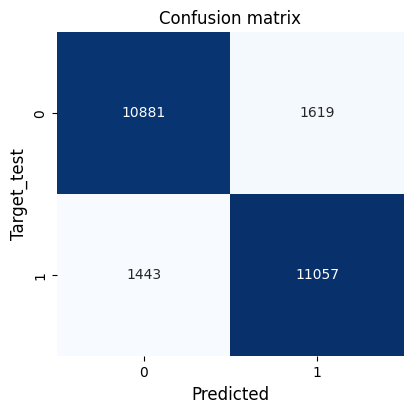

In [54]:
confusion_matrix_map(target_test, predicted_test)

In [55]:
# сохранение модели и проверка загрузки
filename = 'model_status.sav'
pickle.dump(best_model_status, open(filename, 'wb'))

In [56]:
filename = "count_status.pkl"
pickle.dump(count_tf_idf, open(filename, 'wb'))


Теперь построим модель на основе нейросети и посмотрим, как изменится качество предсказаний.

In [57]:
features_train_nn, features_valid_nn, target_train_nn, target_valid_nn = train_test_split(
    train_data['text_clean'], train_data['positive'], test_size=0.20, random_state=RANDOM_STATE, stratify=train_data['positive'])

In [58]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))

tf_idf_train = count_tf_idf.fit_transform(features_train_nn)
tf_idf_valid = count_tf_idf.transform(features_valid_nn)
tf_idf_test = count_tf_idf.transform(features_test['text_clean'])

print("Размер матрицы train:", tf_idf_train.shape)
print("Размер матрицы valid:", tf_idf_valid.shape)
print("Размер матрицы test:", tf_idf_test.shape)

Размер матрицы train: (20000, 55965)
Размер матрицы valid: (5000, 55965)
Размер матрицы test: (25000, 55965)


In [59]:
selector = SelectKBest(chi2, k=10000)

tf_idf_train_slct = selector.fit_transform(tf_idf_train, target_train_nn)
tf_idf_valid_slct = selector.transform(tf_idf_valid)
tf_idf_test_slct = selector.transform(tf_idf_test)

print("Размер матрицы train:", tf_idf_train_slct.shape)
print("Размер матрицы valid:", tf_idf_valid_slct.shape)
print("Размер матрицы test:", tf_idf_test_slct.shape)

Размер матрицы train: (20000, 10000)
Размер матрицы valid: (5000, 10000)
Размер матрицы test: (25000, 10000)


Построим простую нейросеть для бинарной классификации:

In [60]:
def build_neural_network():
    model = tf.keras.Sequential([
        layers.Dense(64, input_shape=(10000, )),
        layers.Dropout(0.5),
        layers.Dense(10, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')

])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

    return model

In [61]:
model_nn = build_neural_network()

In [62]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 640,725
Trainable params: 640,725
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = model_nn.fit(tf_idf_train_slct.toarray(),target_train_nn,
                       epochs=4,
                       batch_size=100,
                       validation_data=(tf_idf_valid_slct.toarray(), target_valid_nn))

Epoch 1/4
200/200 [==============================] - 12s 46ms/step - loss: 0.5229 - binary_accuracy: 0.7659 - val_loss: 0.3126 - val_binary_accuracy: 0.8894
Epoch 2/4
200/200 [==============================] - 4s 21ms/step - loss: 0.2912 - binary_accuracy: 0.9049 - val_loss: 0.2609 - val_binary_accuracy: 0.8956
Epoch 3/4
200/200 [==============================] - 6s 29ms/step - loss: 0.2159 - binary_accuracy: 0.9336 - val_loss: 0.2677 - val_binary_accuracy: 0.8912
Epoch 4/4
200/200 [==============================] - 4s 21ms/step - loss: 0.1753 - binary_accuracy: 0.9508 - val_loss: 0.2950 - val_binary_accuracy: 0.8880


In [64]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Построим график изменения точности и потерь от количества эпох:

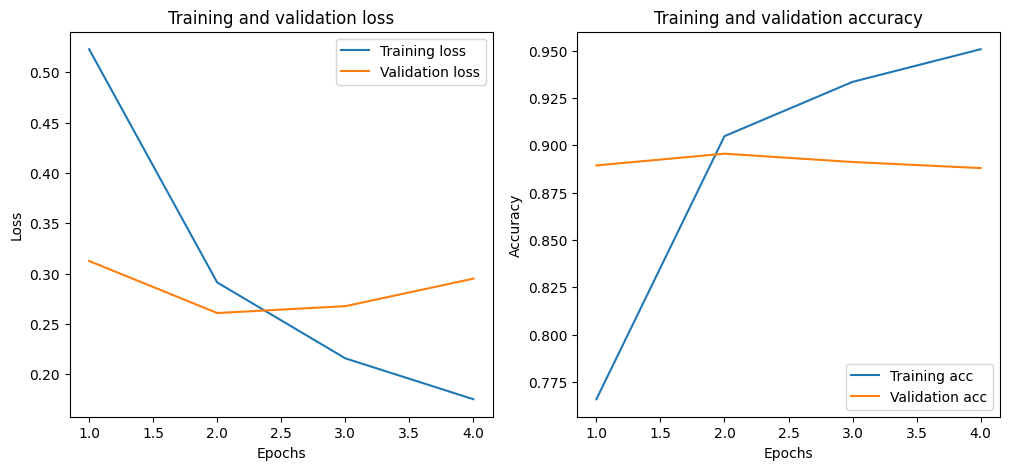

In [65]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Видно, что на валидации потери после 2 эпох начинают возрастать, а точность начинает падать. Это говорит о переобучении модели после 2 эпох. Обучим модель на 2 эпохах и посмотрим на результат:

In [66]:
model_nn = build_neural_network()


history = model_nn.fit(tf_idf_train_slct.toarray(),target_train_nn,
                       epochs=2,
                       batch_size=100,
                       validation_data=(tf_idf_valid_slct.toarray(), target_valid_nn))

Epoch 1/2
200/200 [==============================] - 6s 27ms/step - loss: 0.4999 - binary_accuracy: 0.7951 - val_loss: 0.2956 - val_binary_accuracy: 0.8912
Epoch 2/2
200/200 [==============================] - 4s 21ms/step - loss: 0.2749 - binary_accuracy: 0.9057 - val_loss: 0.2584 - val_binary_accuracy: 0.8984


На валидации accuracy = 89,1%. Это результат сопоставимый с выбранной лучшей ML-моделью SGDClassifier. Вероятно, что более высокую точность можно достичь с помощью эмбиддингов на предобученной модели BERT, но данный процесс занимает много времени и требует более высокие вычислительные ресурсы.

Проверим результат нейросети на тестовых данных:

In [67]:
predictions = model_nn.predict(tf_idf_test_slct.toarray())

782/782 [==============================] - 3s 4ms/step


In [68]:
print(classification_report(target_test, predicted_test))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



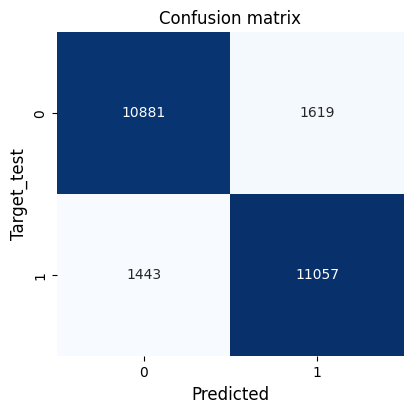

In [69]:
confusion_matrix_map(target_test, predicted_test)

Видим, что результат даже немного хуже, чем у SGDClassifier, и предсказание классов менее равномерное. Поэтому остановимся на более простой модели SGDClassifier, которая дает достаточно хорошие результаты на предобработанном тесте.

In [70]:
model_nn.save('model_status.h5', save_format='h5')
model_nn = tf.keras.models.load_model('model_status.h5')

Предсказание рейтинга

Классические ML-модели

In [71]:
features_train_rat, features_valid_rat, target_train_rat, target_valid_rat = train_test_split(
    train_data['text_clean'], train_data['rating'], test_size=0.20, random_state=RANDOM_STATE, stratify=train_data['rating'])

In [72]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))

tf_idf_train = count_tf_idf.fit_transform(features_train_rat)
tf_idf_valid = count_tf_idf.transform(features_valid_rat)
tf_idf_test = count_tf_idf.transform(features_test['text_clean'])

print("Размер матрицы train:", tf_idf_train.shape)
print("Размер матрицы valid:", tf_idf_valid.shape)
print("Размер матрицы test:", tf_idf_test.shape)

Размер матрицы train: (20000, 56084)
Размер матрицы valid: (5000, 56084)
Размер матрицы test: (25000, 56084)


Проверим несколько классических моделей:

In [73]:
model = LGBMClassifier(n_estimators = 300, random_state=RANDOM_STATE, class_weight='balanced')
model.fit(tf_idf_train, target_train_rat)
predicted_valid = model.predict(tf_idf_valid)

print(classification_report(target_valid_rat, predicted_valid))

              precision    recall  f1-score   support

           1       0.58      0.68      0.62      1020
           2       0.17      0.14      0.16       457
           3       0.22      0.16      0.19       484
           4       0.29      0.29      0.29       539
           7       0.29      0.28      0.29       499
           8       0.24      0.23      0.23       602
           9       0.19      0.15      0.17       453
          10       0.49      0.58      0.53       946

    accuracy                           0.38      5000
   macro avg       0.31      0.31      0.31      5000
weighted avg       0.35      0.38      0.36      5000



In [74]:
model = SGDClassifier(random_state=RANDOM_STATE, class_weight='balanced')
model.fit(tf_idf_train, target_train_rat)
predicted_valid = model.predict(tf_idf_valid)

print(classification_report(target_valid_rat, predicted_valid))

              precision    recall  f1-score   support

           1       0.58      0.76      0.66      1020
           2       0.20      0.13      0.16       457
           3       0.22      0.15      0.18       484
           4       0.30      0.32      0.31       539
           7       0.30      0.32      0.31       499
           8       0.31      0.22      0.25       602
           9       0.17      0.13      0.15       453
          10       0.51      0.62      0.56       946

    accuracy                           0.40      5000
   macro avg       0.32      0.33      0.32      5000
weighted avg       0.37      0.40      0.38      5000



In [75]:
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=300)
model.fit(tf_idf_train, target_train_rat)
predicted_valid = model.predict(tf_idf_valid)

print(classification_report(target_valid_rat, predicted_valid))

              precision    recall  f1-score   support

           1       0.65      0.62      0.63      1020
           2       0.25      0.26      0.25       457
           3       0.24      0.22      0.23       484
           4       0.31      0.32      0.32       539
           7       0.31      0.37      0.34       499
           8       0.29      0.26      0.28       602
           9       0.20      0.21      0.20       453
          10       0.55      0.54      0.55       946

    accuracy                           0.40      5000
   macro avg       0.35      0.35      0.35      5000
weighted avg       0.40      0.40      0.40      5000



Лучшие результаты при предсказании рейтинга показала LogisticRegression с параметрами {class_weight: 'balanced', max_iter: 300}

Дообучим лучшую модель на полной обучающей выборке:

In [76]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))
tf_idf_train_ = count_tf_idf.fit_transform(features_train['text_clean'])
tf_idf_test_ = count_tf_idf.transform(features_test['text_clean'])

print("Размер матрицы:", tf_idf_train_.shape)
print("Размер матрицы:", tf_idf_test_.shape)

Размер матрицы: (25000, 61639)
Размер матрицы: (25000, 61639)


Проверим результаты на тестовой выборке:

In [77]:
best_model_rating = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=300)
best_model_rating.fit(tf_idf_train_, train_data['rating'])
predicted_test = best_model_rating.predict(tf_idf_test_)

print(classification_report(test_data['rating'], predicted_test))

              precision    recall  f1-score   support

           1       0.63      0.60      0.62      5022
           2       0.21      0.21      0.21      2302
           3       0.23      0.22      0.23      2541
           4       0.29      0.33      0.31      2635
           7       0.27      0.30      0.28      2307
           8       0.25      0.22      0.23      2850
           9       0.21      0.22      0.21      2344
          10       0.56      0.54      0.55      4999

    accuracy                           0.38     25000
   macro avg       0.33      0.33      0.33     25000
weighted avg       0.38      0.38      0.38     25000



In [78]:
filename = "model_rating.sav"
pickle.dump(best_model_rating, open(filename, 'wb'))

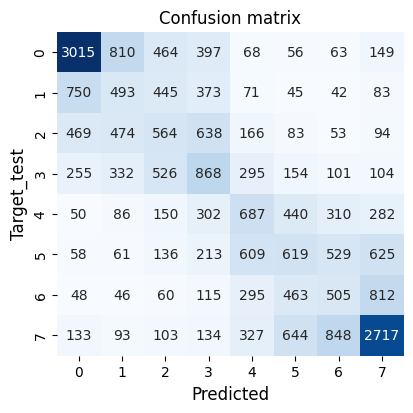

In [79]:
confusion_matrix_map(test_data['rating'], predicted_test)

Результаты именно точных ответов не очень высокие (accuracy = 38%), что объясняется сложностью точного предсказания мультиклассов по сравнению с бинарной классификацией. Однако по матрице ошибок видно достаточно неплохое попадание в соседние (близкие) классы.

Нейросеть

In [80]:
selector = SelectKBest(chi2, k=10000)

tf_idf_train_slct = selector.fit_transform(tf_idf_train, target_train_rat)
tf_idf_valid_slct = selector.transform(tf_idf_valid)
tf_idf_test_slct = selector.transform(tf_idf_test)

print("Размер матрицы train:", tf_idf_train_slct.shape)
print("Размер матрицы valid:", tf_idf_valid_slct.shape)
print("Размер матрицы test:", tf_idf_test_slct.shape)

Размер матрицы train: (20000, 10000)
Размер матрицы valid: (5000, 10000)
Размер матрицы test: (25000, 10000)


Построим простую нейросеть для множественной классификации:

In [81]:
def build_neural_network_rat():
    model = tf.keras.Sequential([
        layers.Dense(128, input_shape=(10000, )),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax')

])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    return model

In [82]:
model_nn_rat = build_neural_network_rat()

In [83]:
history = model_nn_rat.fit(tf_idf_train_slct.toarray(),target_train_rat,
                          epochs=4,
                          batch_size=100,
                          validation_data=(tf_idf_valid_slct.toarray(), target_valid_rat))

Epoch 1/4
200/200 [==============================] - 9s 43ms/step - loss: 2.0615 - sparse_categorical_accuracy: 0.2632 - val_loss: 1.6419 - val_sparse_categorical_accuracy: 0.3830
Epoch 2/4
200/200 [==============================] - 7s 37ms/step - loss: 1.5733 - sparse_categorical_accuracy: 0.3997 - val_loss: 1.4604 - val_sparse_categorical_accuracy: 0.4260
Epoch 3/4
200/200 [==============================] - 7s 37ms/step - loss: 1.3968 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.4337 - val_sparse_categorical_accuracy: 0.4282
Epoch 4/4
200/200 [==============================] - 8s 42ms/step - loss: 1.2790 - sparse_categorical_accuracy: 0.5041 - val_loss: 1.4511 - val_sparse_categorical_accuracy: 0.4266


In [84]:
predictions = model_nn_rat.predict(tf_idf_valid_slct.toarray())

pred=[]
for i in predictions:
    pred.append(np.argmax(i))

print(classification_report(target_valid_rat, pred))

157/157 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           1       0.53      0.81      0.64      1020
           2       0.12      0.00      0.00       457
           3       0.28      0.18      0.22       484
           4       0.32      0.36      0.34       539
           7       0.33      0.31      0.32       499
           8       0.29      0.29      0.29       602
           9       0.28      0.04      0.07       453
          10       0.49      0.72      0.58       946

    accuracy                           0.43      5000
   macro avg       0.33      0.34      0.31      5000
weighted avg       0.37      0.43      0.37      5000



Не смотря на то, что на валидации общая метрика accuracy = 43% у нейросети
получилась больше, чем у LogisticRegression, классы 2 и 9 вообще имеют почти нулевое f1-score. Вероятно, что более высокую точность можно достичь с помощью усложнения модели, например эмбиддингов на предобученной модели BERT, но в условиях ограниченности ресурсов остановим свой выбор на простой модели LogisticRegression.


In [85]:
model_nn_rat.save('model_rating.h5', save_format='h5')
model_nn_rat = tf.keras.models.load_model('model_rating.h5')